In [1]:
# Disable progress bars for small examples
from segysak.progress import Progress

Progress.set_defaults(disable=True)

# Merging Seismic Data Cubes

Often we receive seismic data cubes which we wish to merge that have different geometries. This workflow will guide you through the process of merging two such cubes.

In [2]:
from segysak import create3d_dataset
from scipy.optimize import curve_fit
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from segysak import open_seisnc, create_seismic_dataset

from dask.distributed import Client

# start a dask client for processing
client = Client()

Creating some synthetic seismic surveys for us to play with. The online documentation uses a smaller example, but you can stress dask by commenting the dimension lines for smaller data and uncommenting the large desktop size volumes.

In [3]:
# large desktop size merge
# i1, i2, iN = 100, 750, 651
# x1, x2, xN = 300, 1250, 951
# t1, t2, tN = 0, 1848, 463
# trans_x, trans_y = 10000, 2000

# online example size merge
i1, i2, iN = 650, 750, 101
x1, x2, xN = 1150, 1250, 101
t1, t2, tN = 0, 200, 201
trans_x, trans_y = 9350, 1680

iline = np.linspace(i1, i2, iN, dtype=int)
xline = np.linspace(x1, x2, xN, dtype=int)
twt = np.linspace(t1, t2, tN, dtype=int)

affine_survey1 = Affine2D()
affine_survey1.rotate_deg(20).translate(trans_x, trans_y)

# create an empty dataset and empty coordinates
survey_1 = create_seismic_dataset(twt=twt, iline=iline, xline=xline)
survey_1["cdp_x"] = (("iline", "xline"), np.empty((iN, xN)))
survey_1["cdp_y"] = (("iline", "xline"), np.empty((iN, xN)))

stacked_iline = survey_1.iline.broadcast_like(survey_1.cdp_x).stack(
    {"ravel": (..., "xline")}
)
stacked_xline = survey_1.xline.broadcast_like(survey_1.cdp_x).stack(
    {"ravel": (..., "xline")}
)

points = np.dstack([stacked_iline, stacked_xline])
points_xy = affine_survey1.transform(points[0])
# put xy back in stacked and unstack into survey_1
survey_1["cdp_x"] = stacked_iline.copy(data=points_xy[:, 0]).unstack()
survey_1["cdp_y"] = stacked_iline.copy(data=points_xy[:, 1]).unstack()

# and the same for survey_2 but with a different affine to survey 1
affine_survey2 = Affine2D()
affine_survey2.rotate_deg(120).translate(11000, 3000)

survey_2 = create_seismic_dataset(twt=twt, iline=iline, xline=xline)
survey_2["cdp_x"] = (("iline", "xline"), np.empty((iN, xN)))
survey_2["cdp_y"] = (("iline", "xline"), np.empty((iN, xN)))

stacked_iline = survey_1.iline.broadcast_like(survey_1.cdp_x).stack(
    {"ravel": (..., "xline")}
)
stacked_xline = survey_1.xline.broadcast_like(survey_1.cdp_x).stack(
    {"ravel": (..., "xline")}
)

points = np.dstack([stacked_iline, stacked_xline])
points_xy = affine_survey2.transform(points[0])
# put xy back in stacked and unstack into survey_1
survey_2["cdp_x"] = stacked_iline.copy(data=points_xy[:, 0]).unstack()
survey_2["cdp_y"] = stacked_iline.copy(data=points_xy[:, 1]).unstack()

Let's check that there is a bit of overlap between the two surveys.

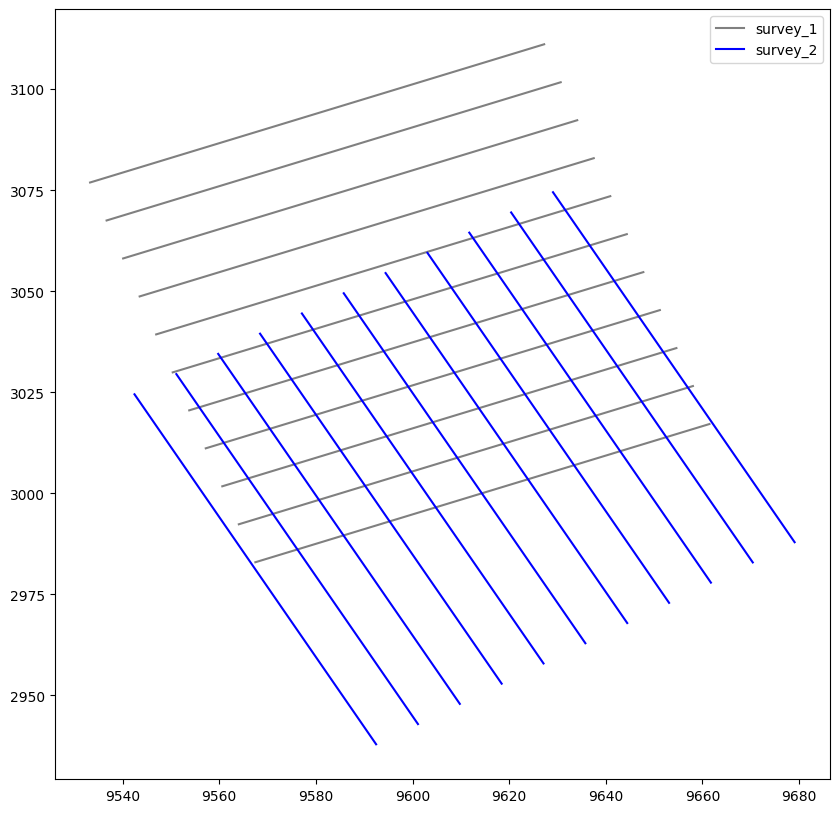

In [4]:
# plotting every 10th line

plt.figure(figsize=(10, 10))
survey_1_plot = plt.plot(
    survey_1.cdp_x.values[::10, ::10], survey_1.cdp_y.values[::10, ::10], color="grey"
)
survey_2_plot = plt.plot(
    survey_2.cdp_x.values[::10, ::10], survey_2.cdp_y.values[::10, ::10], color="blue"
)
# plt.aspect("equal")
plt.legend([survey_1_plot[0], survey_2_plot[0]], ["survey_1", "survey_2"])

Let's output these two datasets to disk so we can use lazy loading from seisnc. If the files are large, it's good practice to do this, because you will probably run out of memory.

We are going to fill survey one with a values of 1 and survey 2 with a value of 2, just for simplicity in this example.
We also tell the dtype to be `np.float32` to reduce memory usage.

In [5]:
# save out with new geometry
survey_1["data"] = (
    ("iline", "xline", "twt"),
    np.full((iN, xN, tN), 1, dtype=np.float32),
)
survey_1.seisio.to_netcdf("data/survey_1.seisnc")
del survey_1
survey_2["data"] = (
    ("iline", "xline", "twt"),
    np.full((iN, xN, tN), 2, dtype=np.float32),
)
survey_2.seisio.to_netcdf("data/survey_2.seisnc")
del survey_2

## How to merge two different geometries

Let us reimport the surveys we created but in a chunked (lazy) way.

In [6]:
survey_1 = open_seisnc("data/survey_1.seisnc", chunks=dict(iline=10, xline=10, twt=100))
survey_2 = open_seisnc("data/survey_2.seisnc", chunks=dict(iline=10, xline=10, twt=100))

/tmp/ipykernel_2004/814101917.py:1: DeprecationWarning: open_seisnc will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(netcdf_file) method instead.
  survey_1 = open_seisnc("data/survey_1.seisnc", chunks=dict(iline=10, xline=10, twt=100))
/tmp/ipykernel_2004/814101917.py:2: DeprecationWarning: open_seisnc will be removed in v0.6, please use the Xarray engine ds = xr.open_dataset(netcdf_file) method instead.
  survey_2 = open_seisnc("data/survey_2.seisnc", chunks=dict(iline=10, xline=10, twt=100))


Check that the survey is chunked by looking at the printout for our datasets. Lazy and chunked data will have a `dask.array<chunksize=` where the values are usually displayed.

In [7]:
survey_1

<xarray.Dataset> Size: 8MB
Dimensions:  (iline: 101, xline: 101, twt: 201)
Coordinates:
  * iline    (iline) int64 808B 650 651 652 653 654 655 ... 746 747 748 749 750
  * xline    (xline) int64 808B 1150 1151 1152 1153 1154 ... 1247 1248 1249 1250
  * twt      (twt) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199 200
    cdp_x    (iline, xline) float64 82kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    cdp_y    (iline, xline) float64 82kB dask.array<chunksize=(10, 10), meta=np.ndarray>
Data variables:
    data     (iline, xline, twt) float32 8MB dask.array<chunksize=(10, 10, 100), meta=np.ndarray>
Attributes: (12/17)
    text:                
    ns:                  None
    sample_rate:         None
    measurement_system:  None
    d3_domain:           None
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

It will help with our other functions if we load the cdp_x and cdp_y locations into memory. This can be done using the `load()` method.

In [8]:
survey_1["cdp_x"] = survey_1["cdp_x"].load()
survey_1["cdp_y"] = survey_1["cdp_y"].load()
survey_2["cdp_x"] = survey_2["cdp_x"].load()
survey_2["cdp_y"] = survey_2["cdp_y"].load()

In [9]:
survey_1

<xarray.Dataset> Size: 8MB
Dimensions:  (iline: 101, xline: 101, twt: 201)
Coordinates:
  * iline    (iline) int64 808B 650 651 652 653 654 655 ... 746 747 748 749 750
  * xline    (xline) int64 808B 1150 1151 1152 1153 1154 ... 1247 1248 1249 1250
  * twt      (twt) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199 200
    cdp_x    (iline, xline) float64 82kB 9.567e+03 9.567e+03 ... 9.627e+03
    cdp_y    (iline, xline) float64 82kB 2.983e+03 2.984e+03 ... 3.111e+03
Data variables:
    data     (iline, xline, twt) float32 8MB dask.array<chunksize=(10, 10, 100), meta=np.ndarray>
Attributes: (12/17)
    text:                
    ns:                  None
    sample_rate:         None
    measurement_system:  None
    d3_domain:           None
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

We will also need an affine transform which converts from il/xl on survey 2 to il/xl on survey 1. This will relate the two grids to each other. Fortunately affine transforms can be added together which makes this pretty straight forward.

In [10]:
ilxl2_to_ilxl1 = (
    survey_2.seis.get_affine_transform()
    + survey_1.seis.get_affine_transform().inverted()
)

Let's check the transform to see if it makes sense. The colouring of our values by inline should be the same after the transform is applied. Cool.

Min Iline: 640.7135889711899 650
Max Iline: 756.5591820391251 750
Min Xline: 1099.1258403243169 1150
Max Xline: 1214.9714333922225 1250
640.7135889711899 756.5591820391251 1099.1258403243169 1250


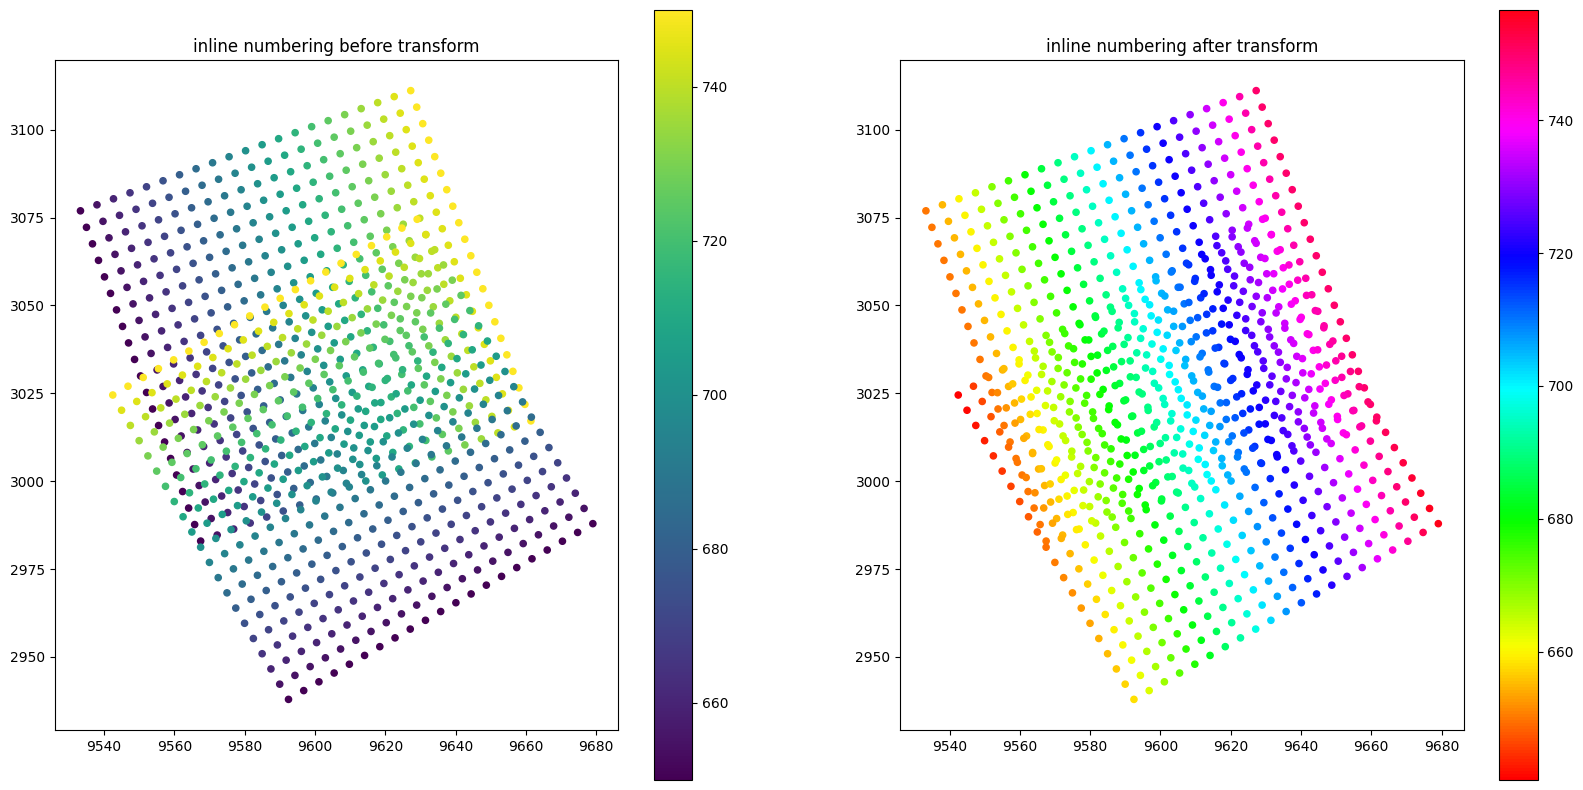

In [11]:
# plotting every 50th line

n = 5

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
survey_1_plot = axs[0].scatter(
    survey_1.cdp_x.values[::n, ::n],
    survey_1.cdp_y.values[::n, ::n],
    c=survey_1.iline.broadcast_like(survey_1.cdp_x).values[::n, ::n],
    s=20,
)
survey_2_plot = axs[0].scatter(
    survey_2.cdp_x.values[::n, ::n],
    survey_2.cdp_y.values[::n, ::n],
    c=survey_2.iline.broadcast_like(survey_2.cdp_x).values[::n, ::n],
    s=20,
)
plt.colorbar(survey_1_plot, ax=axs[0])
axs[0].set_aspect("equal")

axs[0].set_title("inline numbering before transform")

new_ilxl = ilxl2_to_ilxl1.transform(
    np.dstack(
        [
            survey_2.iline.broadcast_like(survey_2.cdp_x).values.ravel(),
            survey_2.xline.broadcast_like(survey_2.cdp_x).values.ravel(),
        ]
    )[0]
).reshape((survey_2.iline.size, survey_2.xline.size, 2))

survey_2.seis.calc_corner_points()
s2_corner_points_in_s1 = ilxl2_to_ilxl1.transform(survey_2.attrs["corner_points"])

print("Min Iline:", s2_corner_points_in_s1[:, 0].min(), survey_1.iline.min().values)
min_iline_combined = min(
    s2_corner_points_in_s1[:, 0].min(), survey_1.iline.min().values
)
print("Max Iline:", s2_corner_points_in_s1[:, 0].max(), survey_1.iline.max().values)
max_iline_combined = max(
    s2_corner_points_in_s1[:, 0].max(), survey_1.iline.max().values
)

print("Min Xline:", s2_corner_points_in_s1[:, 1].min(), survey_1.xline.min().values)
min_xline_combined = min(
    s2_corner_points_in_s1[:, 1].min(), survey_1.xline.min().values
)
print("Max Xline:", s2_corner_points_in_s1[:, 1].max(), survey_1.xline.max().values)
max_xline_combined = max(
    s2_corner_points_in_s1[:, 1].max(), survey_1.xline.max().values
)
print(min_iline_combined, max_iline_combined, min_xline_combined, max_xline_combined)

survey_1_plot = axs[1].scatter(
    survey_1.cdp_x.values[::n, ::n],
    survey_1.cdp_y.values[::n, ::n],
    c=survey_1.iline.broadcast_like(survey_1.cdp_x).values[::n, ::n],
    vmin=min_iline_combined,
    vmax=max_iline_combined,
    s=20,
    cmap="hsv",
)


survey_2_plot = axs[1].scatter(
    survey_2.cdp_x.values[::n, ::n],
    survey_2.cdp_y.values[::n, ::n],
    c=new_ilxl[::n, ::n, 0],
    vmin=min_iline_combined,
    vmax=max_iline_combined,
    s=20,
    cmap="hsv",
)
plt.colorbar(survey_1_plot, ax=axs[1])

axs[1].set_title("inline numbering after transform")
axs[1].set_aspect("equal")

So we now have a transform that can convert ilxl from `survey_2` to ilxl from `survey_1` and we need to create a combined geometry for the merge. The dims need to cover the maximum range (inline, crossline) of two surveys. We are also going to use survey 1 as the base as we don't want to have to resample two cubes, although if you have a prefered geometry you could do that (custom affine transforms per survey required).

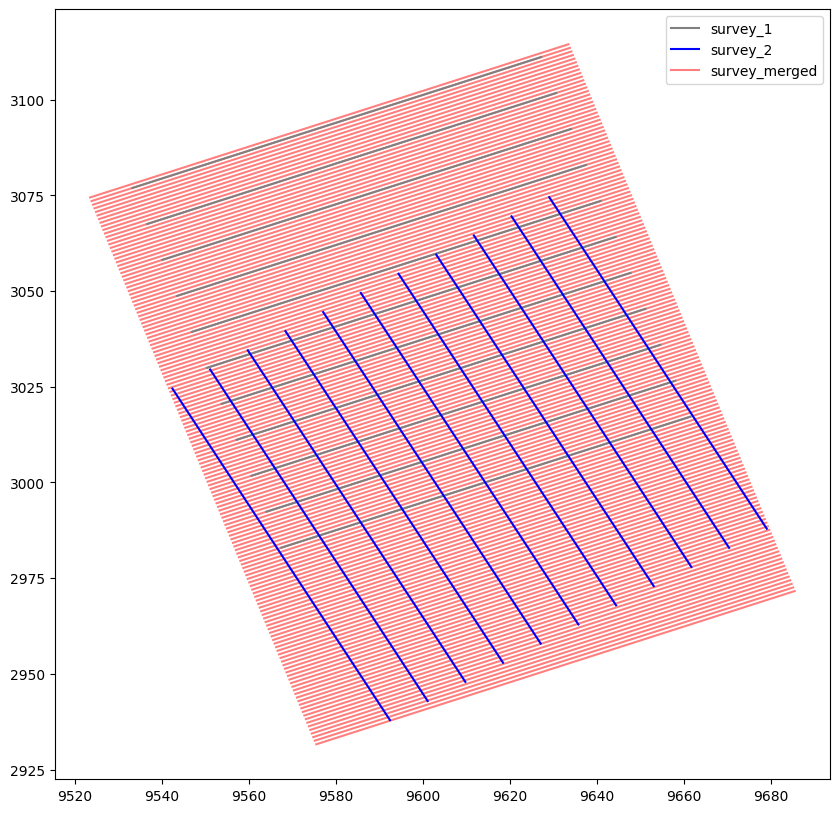

In [12]:
# create new dims
iline_step = survey_1.iline.diff("iline").mean().values
xline_step = survey_1.xline.diff("xline").mean().values

# create the new dimensions
new_iline_dim = np.arange(
    int(min_iline_combined // iline_step) * iline_step,
    int(max_iline_combined) + iline_step * 2,
    iline_step,
    dtype=np.int32,
)
new_xline_dim = np.arange(
    int(min_xline_combined // xline_step) * xline_step,
    int(max_xline_combined) + xline_step * 2,
    xline_step,
    dtype=np.int32,
)

# create a new empty dataset and a blank cdp_x for dims broadcasting
survey_comb = create_seismic_dataset(
    iline=new_iline_dim, xline=new_xline_dim, twt=survey_1.twt
)
survey_comb["cdp_x"] = (
    ("iline", "xline"),
    np.empty((new_iline_dim.size, new_xline_dim.size)),
)

# calculate the x and y using the survey 1 affine which is our base grid and reshape to the dataset grid
new_cdp_xy = affine_survey1.transform(
    np.dstack(
        [
            survey_comb.iline.broadcast_like(survey_comb.cdp_x).values.ravel(),
            survey_comb.xline.broadcast_like(survey_comb.cdp_x).values.ravel(),
        ]
    )[0]
)
new_cdp_xy_grid = new_cdp_xy.reshape((new_iline_dim.size, new_xline_dim.size, 2))

# plot to check
plt.figure(figsize=(10, 10))

survey_comb_plot = plt.plot(
    new_cdp_xy_grid[:, :, 0], new_cdp_xy_grid[:, :, 1], color="red", alpha=0.5
)
survey_1_plot = plt.plot(
    survey_1.cdp_x.values[::10, ::10], survey_1.cdp_y.values[::10, ::10], color="grey"
)
survey_2_plot = plt.plot(
    survey_2.cdp_x.values[::10, ::10], survey_2.cdp_y.values[::10, ::10], color="blue"
)

plt.legend(
    [survey_1_plot[0], survey_2_plot[0], survey_comb_plot[0]],
    ["survey_1", "survey_2", "survey_merged"],
)

# put the new x and y in the empty dataset
survey_comb["cdp_x"] = (("iline", "xline"), new_cdp_xy_grid[..., 0])
survey_comb["cdp_y"] = (("iline", "xline"), new_cdp_xy_grid[..., 1])
survey_comb = survey_comb.set_coords(("cdp_x", "cdp_y"))

## Resampling `survey_2` to `survey_1` geometry

Resampling one dataset to another requires us to tell Xarray/dask where we want the new traces to be. First we can convert the x and y coordinates of the combined survey to the il xl of survey 2 using the affine transform of survey 2. This transform works il/xl to x and y and therefore we need it inverted.

In [13]:
survey_2_new_ilxl_loc = affine_survey2.inverted().transform(new_cdp_xy)

We then need to create a sampling DataArray. If we passed the iline and cross line locations from the previous cell unfortunately Xarray would broadcast the inline and xline values against each other. The simplest way is to create a new stacked flat dimension which we can unstack into a cube later.

We also need to give it unique names so xarray doesn't confuse the new dimensions with the old dimensions.

In [14]:
flat = (
    survey_comb.rename(  # use the combined survey
        {"iline": "new_iline", "xline": "new_xline"}
    )  # renaming inline and xline so they don't confuse xarray
    .stack(
        {"flat": ("new_iline", "new_xline")}
    )  # and flatten the iline and xline axes using stack
    .flat  # return just the flat coord object which is multi-index (so we can unstack later)
)
flat

<xarray.DataArray 'flat' (flat: 18054)> Size: 144kB
array([(640, 1099), (640, 1100), (640, 1101), ..., (757, 1249), (757, 1250),
       (757, 1251)], dtype=object)
Coordinates:
    cdp_x      (flat) float64 144kB 9.576e+03 9.575e+03 ... 9.634e+03 9.633e+03
    cdp_y      (flat) float64 144kB 2.932e+03 2.933e+03 ... 3.114e+03 3.114e+03
  * flat       (flat) object 144kB MultiIndex
  * new_iline  (flat) int32 72kB 640 640 640 640 640 640 ... 757 757 757 757 757
  * new_xline  (flat) int32 72kB 1099 1100 1101 1102 ... 1248 1249 1250 1251

In [15]:
# create a dictionary of new coordinates to sample to. We use flat here because it will easily allow us to
# unstack the data after interpolation. It's necessary to use this flat dataset, otherwise xarray will try to
# interpolate on the cartesian product of iline and xline, which isn't really what we want.

resampling_data_arrays = dict(
    iline=xr.DataArray(survey_2_new_ilxl_loc[:, 0], dims="flat", coords={"flat": flat}),
    xline=xr.DataArray(survey_2_new_ilxl_loc[:, 1], dims="flat", coords={"flat": flat}),
)

resampling_data_arrays

{'iline': <xarray.DataArray (flat: 18054)> Size: 144kB
 array([653.01535386, 654.00016161, 654.98496936, ..., 780.41968002,
        781.40448778, 782.38929553])
 Coordinates:
   * flat       (flat) object 144kB MultiIndex
   * new_iline  (flat) int32 72kB 640 640 640 640 640 640 ... 757 757 757 757 757
   * new_xline  (flat) int32 72kB 1099 1100 1101 1102 ... 1248 1249 1250 1251,
 'xline': <xarray.DataArray (flat: 18054)> Size: 144kB
 array([1267.82560706, 1267.65195888, 1267.47831071, ..., 1126.55587331,
        1126.38222513, 1126.20857695])
 Coordinates:
   * flat       (flat) object 144kB MultiIndex
   * new_iline  (flat) int32 72kB 640 640 640 640 640 640 ... 757 757 757 757 757
   * new_xline  (flat) int32 72kB 1099 1100 1101 1102 ... 1248 1249 1250 1251}

The resampling can take a while with larger cubes, so it is good to use dask and to output the cube to disk at this step.
When using dask for processing it is better to output to disk regularly, as this will improve how your code runs and the overall memory usage.

*If you are executing this exmample locally, the task progress can be viewed by opening the dask [client](http://localhost:8787/status).*

In [16]:
survey_2_resamp = survey_2.interp(**resampling_data_arrays)
survey_2_resamp_newgeom = (
    survey_2_resamp.drop_vars(("iline", "xline"))
    .unstack("flat")
    .rename({"new_iline": "iline", "new_xline": "xline"})
    .data
)
survey_2_resamp_newgeom.to_netcdf("data/survey_2_1.nc", compute=True, engine="h5netcdf")

## Combining Cubes

The last step is combining the cube is to load the two datasets to be combined and concatenate them together along a new axis. This will simplify reduction processes later.

In [17]:
survey_2_resamp_newgeom = xr.open_dataarray(
    "data/survey_2_1.nc", chunks=dict(iline=10, xline=10, twt=100), engine="h5netcdf"
)

In [18]:
survey_2_resamp_newgeom.expand_dims({"survey": [2]})

<xarray.DataArray 'data' (survey: 1, twt: 201, iline: 118, xline: 153)> Size: 15MB
dask.array<broadcast_to, shape=(1, 201, 118, 153), dtype=float32, chunksize=(1, 100, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * survey   (survey) int64 8B 2
  * iline    (iline) int32 472B 640 641 642 643 644 645 ... 753 754 755 756 757
  * xline    (xline) int32 612B 1099 1100 1101 1102 1103 ... 1248 1249 1250 1251
  * twt      (twt) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199 200
    cdp_x    (iline, xline) float64 144kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    cdp_y    (iline, xline) float64 144kB dask.array<chunksize=(10, 10), meta=np.ndarray>

In [19]:
# concatenate survey with new dimension "survey".
survey_comb["data"] = xr.concat([survey_1.data, survey_2_resamp_newgeom], "survey")

/home/runner/.local/share/hatch/env/virtual/segysak/7aGXAoce/docs/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


In [20]:
survey_comb

<xarray.Dataset> Size: 29MB
Dimensions:  (iline: 118, xline: 153, twt: 201, survey: 2)
Coordinates:
  * iline    (iline) int64 944B 640 641 642 643 644 645 ... 753 754 755 756 757
  * xline    (xline) int64 1kB 1099 1100 1101 1102 1103 ... 1248 1249 1250 1251
  * twt      (twt) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199 200
    cdp_x    (iline, xline) float64 144kB 9.576e+03 9.575e+03 ... 9.633e+03
    cdp_y    (iline, xline) float64 144kB 2.932e+03 2.933e+03 ... 3.114e+03
Dimensions without coordinates: survey
Data variables:
    data     (survey, iline, xline, twt) float32 29MB dask.array<chunksize=(1, 9, 9, 100), meta=np.ndarray>
Attributes: (12/17)
    ns:                  None
    sample_rate:         None
    text:                None
    measurement_system:  None
    d3_domain:           None
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

We can check the merged surveys by looking at some plots. If we select just the first survey the values will be 1. If we select just the second survey the values will be 2. And if we take the mean along the survey dimension, then where the surveys overlap the values will be 1.5.

For seismic data, a better form of conditioning and reduction might be required for merging traces together to ensure a smoother seam.

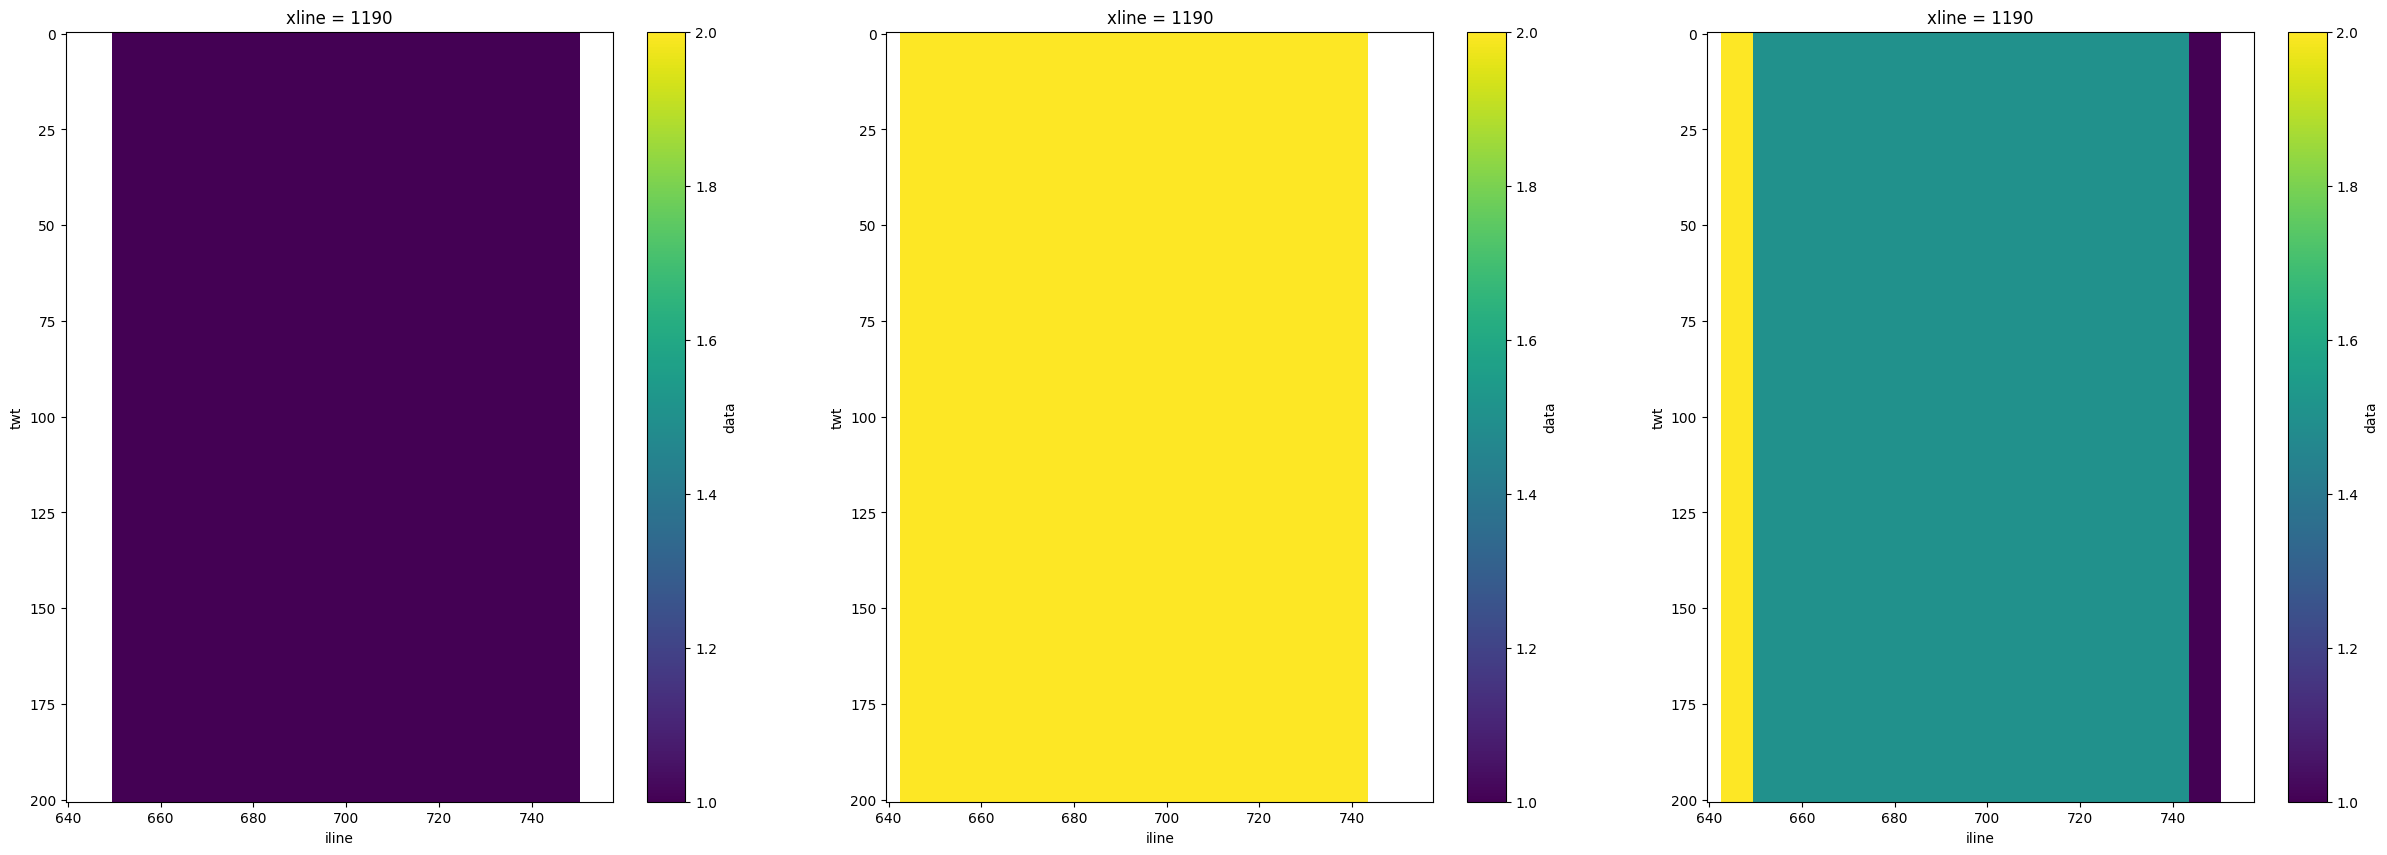

In [21]:
sel = survey_comb.sel(xline=1190)

fig, axs = plt.subplots(ncols=3, figsize=(30, 10))

sel.isel(survey=0).data.T.plot(ax=axs[0], yincrease=False, vmin=1, vmax=2)
sel.isel(survey=1).data.T.plot(ax=axs[1], yincrease=False, vmin=1, vmax=2)
sel.data.mean("survey").T.plot(ax=axs[2], yincrease=False, vmin=1, vmax=2)

In [22]:
survey_comb.twt

<xarray.DataArray 'twt' (twt: 201)> Size: 2kB
array([  0,   1,   2, ..., 198, 199, 200])
Coordinates:
  * twt      (twt) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199 200

And if we inspect a time slice.

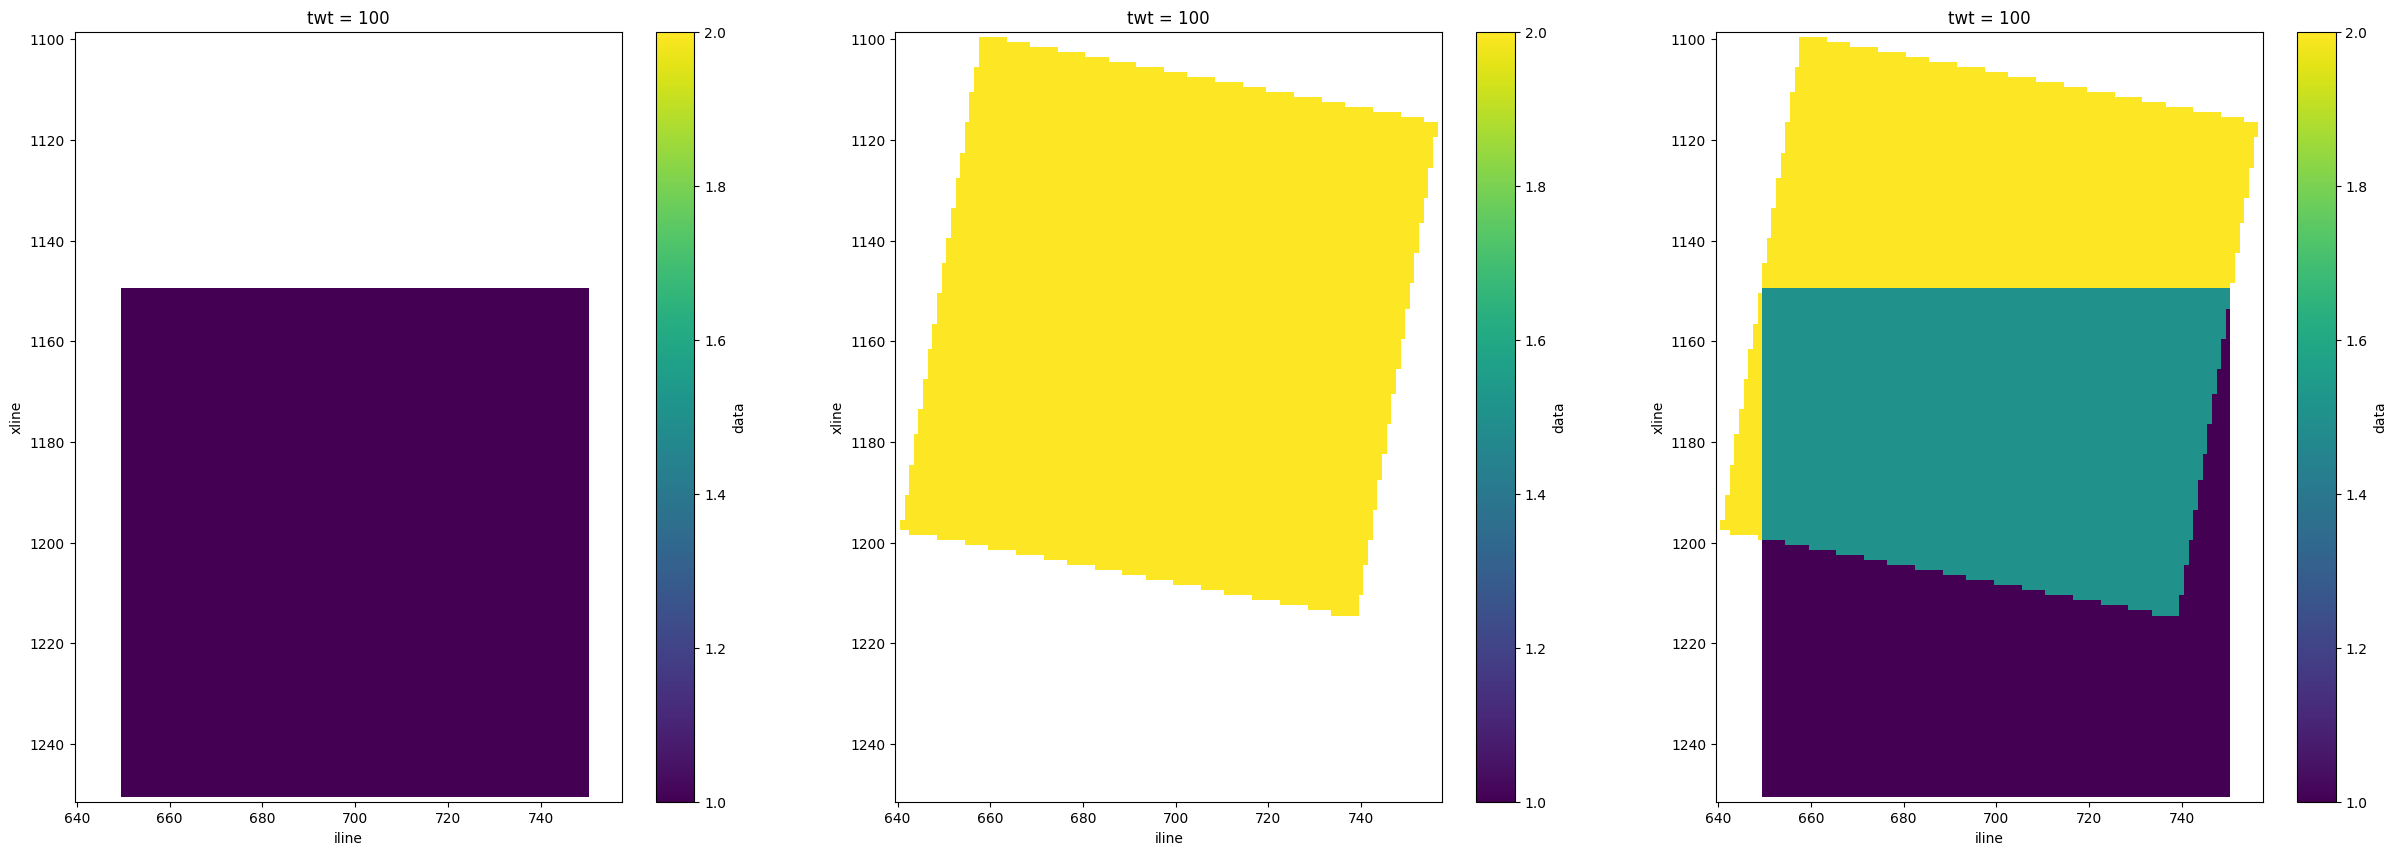

In [23]:
sel = survey_comb.sel(twt=100)

fig, axs = plt.subplots(ncols=3, figsize=(30, 10))

sel.isel(survey=0).data.T.plot(ax=axs[0], yincrease=False, vmin=1, vmax=2)
sel.isel(survey=1).data.T.plot(ax=axs[1], yincrease=False, vmin=1, vmax=2)
sel.data.mean("survey").T.plot(ax=axs[2], yincrease=False, vmin=1, vmax=2)